In [4]:
import open3d as o3d
import numpy as np

In [9]:
print("Load a ply point cloud, print it, and render it")
ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud(ply_point_cloud.path) # PLY -> Polygon File Format
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

# It looks like a dense surface, but it is actually a point cloud rendered as surfels
# use + and - keys (at top, not on numpad in right) to increase the density (change the size of the points / surfels)

Load a ply point cloud, print it, and render it
PointCloud with 196133 points.
[[0.65234375 0.84686458 2.37890625]
 [0.65234375 0.83984375 2.38430572]
 [0.66737998 0.83984375 2.37890625]
 ...
 [2.00839925 2.39453125 1.88671875]
 [2.00390625 2.39488506 1.88671875]
 [2.00390625 2.39453125 1.88793314]]


Voxel Downsampling

In [10]:
# Voxel downsampling uses a regular voxel grid to create a uniformly downsampled point cloud from an input point cloud.
# 1) Points are bucketed into voxels.
# 2) Each occupied voxel generates exactly one point by averaging all points inside.

print("Downsample the point cloud with a voxel of 0.05")
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Downsample the point cloud with a voxel of 0.05


Vertex normal estimation

In [12]:
print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
o3d.visualization.draw_geometries([downpcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True)

# estimate_normals computes the normal for every point. 
# The function finds adjacent points and calculates the principal axis of the adjacent points using covariance analysis.

# The function takes an instance of KDTreeSearchParamHybrid class as an argument. 
# The two key arguments radius = 0.1 and max_nn = 30 specifies search radius and maximum nearest neighbor. 
# It has 10cm of search radius, and only considers up to 30 neighbors to save computation time.

# The covariance analysis algorithm produces two opposite directions as normal candidates. 
# Without knowing the global structure of the geometry, both can be correct. This is known as the normal orientation problem. 
# Open3D tries to orient the normal to align with the original normal if it exists. Otherwise, Open3D does a random guess. 
# Further orientation functions such as orient_normals_to_align_with_direction and 
# orient_normals_towards_camera_location need to be called if the orientation is a concern.

Recompute the normal of the downsampled point cloud


Access Estimated Vertex Normals

In [13]:
print("Print a normal vector of the 0th point")
print(downpcd.normals[0])

Print a normal vector of the 0th point
[-0.27566603 -0.89197839 -0.35830543]


In [ ]:
# Normal vectors can be transformed as a numpy array using np.asarray.
print("Print the normal vectors of the first 10 points")
print(np.asarray(downpcd.normals)[:10, :])

Crop Point Cloud

In [14]:
print("Load a polygon volume and use it to crop the original point cloud")
demo_crop_data = o3d.data.DemoCropPointCloud()
pcd = o3d.io.read_point_cloud(demo_crop_data.point_cloud_path) 
vol = o3d.visualization.read_selection_polygon_volume(demo_crop_data.cropped_json_path) # # reads a json file that specifies polygon selection area.
chair = vol.crop_point_cloud(pcd) # filters out points. Only the chair remains.
o3d.visualization.draw_geometries([chair],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])

Load a polygon volume and use it to crop the original point cloud
[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/DemoCropPointCloud.zip
[Open3D INFO] Downloaded to /home/siddharth/open3d_data/download/DemoCropPointCloud/DemoCropPointCloud.zip
[Open3D INFO] Created directory /home/siddharth/open3d_data/extract/DemoCropPointCloud.
[Open3D INFO] Extracting /home/siddharth/open3d_data/download/DemoCropPointCloud/DemoCropPointCloud.zip.
[Open3D INFO] Extracted to /home/siddharth/open3d_data/extract/DemoCropPointCloud.


Paint point cloud

In [15]:
print("Paint chair")
chair.paint_uniform_color([1, 0.706, 0]) # RGB composition in order, b/w [0, 1]
o3d.visualization.draw_geometries([chair],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])

Paint chair


Point cloud distance

In [18]:
# Open3D provides the method compute_point_cloud_distance to compute the distance from a source point cloud to a target point cloud. 
# I.e., it computes for each point in the source point cloud the distance to the closest point in the target point cloud.
# this method could also be used to compute the Chamfer distance between two point clouds.

# Load data
demo_crop_data = o3d.data.DemoCropPointCloud()
pcd = o3d.io.read_point_cloud(demo_crop_data.point_cloud_path)
vol = o3d.visualization.read_selection_polygon_volume(demo_crop_data.cropped_json_path)
chair = vol.crop_point_cloud(pcd)

dists = pcd.compute_point_cloud_distance(chair)
dists = np.asarray(dists)
ind = np.where(dists > 0.01)[0]
pcd_without_chair = pcd.select_by_index(ind)
o3d.visualization.draw_geometries([pcd_without_chair],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])


Chamfer Distance

Chamfer Distance: 0.253492972600424


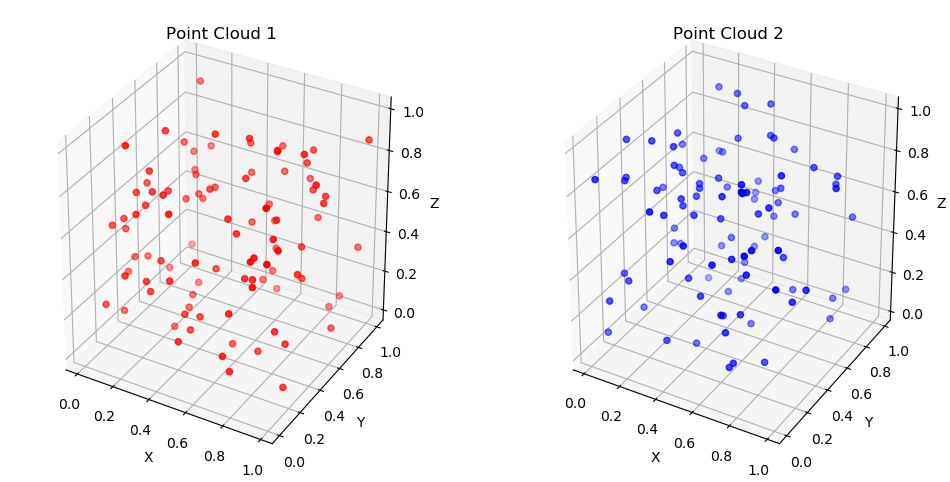

In [17]:
# Chamfer distance is a metric used to evaluate the similarity between two sets of points.

# Given two point sets A and B, the chamfer distance is defined as the sum of the distances from each point in A to its nearest neighbor in B, 
# plus the sum of the distances from each point in B to its nearest neighbor in A.

# By minimizing the chamfer distance between the point sets, one can find the best alignment between them.

from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random point clouds
def generate_random_point_cloud(n_points, dim=3):
    return np.random.rand(n_points, dim)

def chamfer_distance(point_cloud1, point_cloud2):
    # Build KD-trees for both point clouds
    tree1 = KDTree(point_cloud1)
    tree2 = KDTree(point_cloud2)
    
    # Compute nearest neighbor distances from point_cloud1 to point_cloud2
    distances1, _ = tree2.query(point_cloud1)
    
    # Compute nearest neighbor distances from point_cloud2 to point_cloud1
    distances2, _ = tree1.query(point_cloud2)
    
    # Chamfer distance is the average of the distances in both directions
    chamfer_dist = np.mean(distances1) + np.mean(distances2)
    return chamfer_dist

# Parameters
n_points = 100  # Number of points in each point cloud

# Generate random point clouds
point_cloud1 = generate_random_point_cloud(n_points)
point_cloud2 = generate_random_point_cloud(n_points)

# Compute Chamfer distance
chamfer_dist = chamfer_distance(point_cloud1, point_cloud2)
print(f"Chamfer Distance: {chamfer_dist}")

# Visualization
fig = plt.figure(figsize=(12, 6))

# Plot point cloud 1
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(point_cloud1[:, 0], point_cloud1[:, 1], point_cloud1[:, 2], c='r', marker='o')
ax1.set_title('Point Cloud 1')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot point cloud 2
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(point_cloud2[:, 0], point_cloud2[:, 1], point_cloud2[:, 2], c='b', marker='o')
ax2.set_title('Point Cloud 2')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()



Bounding Volumes

In [19]:
aabb = chair.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0) # red
obb = chair.get_oriented_bounding_box()
obb.color = (0, 1, 0) # green
o3d.visualization.draw_geometries([chair, aabb, obb],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])

Convex Hull

In [20]:
# The convex hull of a point cloud is the smallest convex set that contains all points.

bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)
mesh.compute_vertex_normals()

pcl = mesh.sample_points_poisson_disk(number_of_points=2000)
hull, _ = pcl.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcl, hull_ls])

[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/BunnyMesh.ply
[Open3D INFO] Downloaded to /home/siddharth/open3d_data/download/BunnyMesh/BunnyMesh.ply


DBSCAN clustering


In [22]:
# The algorithm is implemented in cluster_dbscan and requires two parameters: 
# eps defines the distance to neighbors in a cluster and min_points defines the minimum number of points required to form a cluster. 
# The function returns labels, where the label -1 indicates noise.

ply_point_cloud = o3d.data.PLYPointCloud() # loads a sample point cloud in the .ply format using Open3D's built-in dataset loader.
pcd = o3d.io.read_point_cloud(ply_point_cloud.path)

with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm: labels = np.array(pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.                     ] 2%
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 10
Precompute neighbors.[================>           point cloud has 10 clusters
Precompute neighbors.[========================================] 100%


Plane segmentation

In [23]:
pcd_point_cloud = o3d.data.PCDPointCloud()
pcd = o3d.io.read_point_cloud(pcd_point_cloud.path)

plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/fragment.pcd
[Open3D INFO] Downloaded to /home/siddharth/open3d_data/download/PCDPointCloud/fragment.pcd
Plane equation: -0.05x + -0.10y + 0.99z + -1.06 = 0


Planar Patch Detection

In [24]:
dataset = o3d.data.PCDPointCloud()
pcd = o3d.io.read_point_cloud(dataset.path)
assert (pcd.has_normals())

# using all defaults
oboxes = pcd.detect_planar_patches(
    normal_variance_threshold_deg=60,
    coplanarity_deg=75,
    outlier_ratio=0.75,
    min_plane_edge_length=0,
    min_num_points=0,
    search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))

print("Detected {} patches".format(len(oboxes)))

geometries = []
for obox in oboxes:
    mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
    mesh.paint_uniform_color(obox.color)
    geometries.append(mesh)
    geometries.append(obox)
geometries.append(pcd)

o3d.visualization.draw_geometries(geometries,
                                  zoom=0.62,
                                  front=[0.4361, -0.2632, -0.8605],
                                  lookat=[2.4947, 1.7728, 1.5541],
                                  up=[-0.1726, -0.9630, 0.2071])

Detected 10 patches


Hidden Point Removal

In [26]:
# Imagine you want to render a point cloud from a given view point, 
# but points from the background leak into the foreground because they are not occluded by other points. 
# For this purpose we can apply a hidden point removal algorithm

print("Convert mesh to a point cloud and estimate dimensions")
armadillo = o3d.data.ArmadilloMesh()
mesh = o3d.io.read_triangle_mesh(armadillo.path)
mesh.compute_vertex_normals()

pcd = mesh.sample_points_poisson_disk(5000)
diameter = np.linalg.norm(
    np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))
o3d.visualization.draw_geometries([pcd])

Convert mesh to a point cloud and estimate dimensions
[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/ArmadilloMesh.ply
[Open3D INFO] Downloaded to /home/siddharth/open3d_data/download/ArmadilloMesh/ArmadilloMesh.ply


In [27]:
print("Define parameters used for hidden_point_removal")
camera = [0, 0, diameter]
radius = diameter * 100

print("Get all points that are visible from given view point")
_, pt_map = pcd.hidden_point_removal(camera, radius)

print("Visualize result")
pcd = pcd.select_by_index(pt_map)
o3d.visualization.draw_geometries([pcd])

Define parameters used for hidden_point_removal
Get all points that are visible from given view point
Visualize result
